# 当当网-G7-02

# 代码简介

* 已清洗好的数据放在：python_books_clean.xlsx中
* 此代码会将数据做可视化处理，帮助分析以下内容
  * 销量排名前 10 的 Python 类图书清单？
  * 销量前 50 的 Python 类图书主要涵盖了哪些领域？比如，编程技巧、数据分析、机器学习和深度学习、青少年编程等 (可以自行定义)
  * 销量前 50 的 Python 类图书中，哪些出版社的书籍比较多？
  * 销量前 50 的 Python 类图书中，原价和折后价的分布，折扣率的分布特征。

# 1. 读取并检查文件

In [7]:
# 1. 读取并检查文件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import re
from IPython.display import display, HTML

# 设置中文字体
# 方案1：使用苹果系统自带的中文字体
plt.rcParams['font.sans-serif'] = ['PingFang HK']

# 方案2：使用其他常见中文字体
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # 或者 'STHeiti'

# 辅助函数：按指定长度自动换行
def wrap_text(text, max_len=10):
    """将文本按指定长度自动换行"""
    if not isinstance(text, str):
        text = str(text)
    
    wrapped = []
    while text:
        wrapped.append(text[:max_len])
        text = text[max_len:]
    
    return '<br>'.join(wrapped)

# 辅助函数：美化表格显示（纯文本样式）
def display_table(df, columns, max_widths, title=None):
    """使用HTML格式化显示表格（纯文本样式）"""
    # 创建表头
    headers = []
    for col in columns:
        wrapped_header = wrap_text(col, max_len=10)
        headers.append(f'<th style="text-align:left; padding:5px; border-bottom:1px solid #000;">{wrapped_header}</th>')
    
    # 创建表格行
    rows = []
    for _, row in df.iterrows():
        row_cells = []
        for col in columns:
            # 获取列对应的原始数据
            value = row[col] if col in row else ''
            
            # 根据列设置最大宽度
            max_width = max_widths.get(col, 10)
            
            # 处理数值类型，保留两位小数
            if isinstance(value, (int, float)):
                value_str = f"{value:.2f}" if isinstance(value, float) else str(value)
            else:
                value_str = str(value)
            
            # 自动换行
            wrapped_value = wrap_text(value_str, max_len=max_width)
            row_cells.append(f'<td style="text-align:left; padding:5px; border-bottom:1px solid #eee;">{wrapped_value}</td>')
        
        rows.append(f'<tr>{"".join(row_cells)}</tr>')
    
    # 构建完整HTML表格
    table_html = f'''
    <div style="margin:15px 0;">
        {f'<h4>{title}</h4>' if title else ''}
        <table style="border-collapse:collapse; width:100%;">
            <thead>
                <tr>{"".join(headers)}</tr>
            </thead>
            <tbody>
                {"".join(rows)}
            </tbody>
        </table>
    </div>
    '''
    
    # 显示表格
    display(HTML(table_html))

# 读取数据
try:
    df = pd.read_excel('data_clean/python_books_clean.xlsx')
    print("数据读取成功，共有", len(df), "条记录")
    
    # 显示数据集行数和列数
    rows, columns = df.shape
    
    if rows == 0:
        print("错误：数据集中没有记录！")
    else:
        # 显示数据集行数和列数
        print(f"数据包含 {rows} 行，{columns} 列")
        
        # 检查数据列名
        expected_columns = ['title', 'author', 'year', 'publisher', 'review_count', 'original_price', 'discounted_price', '页面排名']
        missing_columns = [col for col in expected_columns if col not in df.columns]
        
        if missing_columns:
            print("\n警告：数据缺少以下列：", ', '.join(missing_columns))
            print("请确保使用正确的列名：", ', '.join(expected_columns))
        
        # 数据预处理
        print("\n开始数据预处理...")
        
        # 复制数据（使用深拷贝避免链式赋值警告）
        df_processed = df.copy(deep=True)
        
        # 将列名转为小写
        df_processed.columns = df_processed.columns.str.strip().str.lower()
        
        # 处理缺失值
        missing_values = df_processed.isnull().sum()
        if missing_values.sum() > 0:
            print("\n处理缺失值：")
            print(missing_values[missing_values > 0])
            
            # 根据数据类型填充缺失值
            for col in df_processed.columns:
                if df_processed[col].dtype == 'object':
                    df_processed[col] = df_processed[col].fillna('未知')
                else:
                    df_processed[col] = df_processed[col].fillna(df_processed[col].median())
        
        # 处理异常值
        if 'original_price' in df_processed.columns and 'discounted_price' in df_processed.columns:
            # 确保价格非负
            df_processed = df_processed[(df_processed['original_price'] >= 0) & 
                                        (df_processed['discounted_price'] >= 0)]
            
            # 确保折扣价不高于原价
            df_processed = df_processed[df_processed['discounted_price'] <= df_processed['original_price']]
            
            # 计算折扣率
            df_processed['discount_rate'] = 1 - df_processed['discounted_price'] / df_processed['original_price']
            
            # 移除折扣率异常值
            df_processed = df_processed[(df_processed['discount_rate'] >= 0) & (df_processed['discount_rate'] <= 1)]
        
        if 'review_count' in df_processed.columns:
            # 确保评论数非负
            df_processed = df_processed[df_processed['review_count'] >= 0]
        
        if 'year' in df_processed.columns:
            # 处理年份异常值
            current_year = pd.Timestamp.now().year
            df_processed = df_processed[(df_processed['year'] >= 2000) & (df_processed['year'] <= current_year)]
        
        print(f"数据预处理完成，剩余 {len(df_processed)} 条有效记录")
        
        # 显示数据基本信息
        print("\n数据基本信息：")
        df.info()
        
        # 显示数据前几行
        print("\n数据前几行内容信息：")
        head_df = df_processed.head()
        
        # 定义列和最大宽度
        columns = head_df.columns.tolist()
        max_widths = {col: 10 for col in columns}
        
        # 显示表格
        display_table(head_df, columns, max_widths)

except FileNotFoundError:
    print("错误：找不到数据文件！请确保data_clean文件夹中的python_books_clean.xlsx文件存在。")
except Exception as e:
    print(f"错误：发生了一个未知错误: {e}")
    df_processed = None

数据读取成功，共有 50 条记录
数据包含 50 行，8 列

开始数据预处理...

处理缺失值：
year                12
original_price       3
discounted_price     1
dtype: int64
数据预处理完成，剩余 50 条有效记录

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             50 non-null     object 
 1   author            50 non-null     object 
 2   year              38 non-null     float64
 3   publisher         50 non-null     object 
 4   review_count      50 non-null     int64  
 5   original_price    47 non-null     float64
 6   discounted_price  49 non-null     float64
 7   页面排名              50 non-null     int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ KB

数据前几行内容信息：


title,author,year,publisher,review_count,original_price,discounted_price,页面排名,discount_rate
小学生Python创意编程（视频教学版）,刘凤飞,2024.00,清华大学出版社,7332,89.00,84.60,1,0.05
Python编程从入门到实践 第3版,埃里克·马瑟斯,2023.00,人民邮电出版社,20216,109.80,69.80,2,0.36
Python股票量化交易从入门到实践,袁霄,2021.00,人民邮电出版社,4498,99.80,94.80,3,0.05
Python从入门到精通（第3版）,明日科技,2023.00,清华大学出版社,2438,89.80,85.30,4,0.05
深度学习入门 基于Python的理论与实现,斋藤康毅,2021.00,人民邮电出版社,14356,69.80,39.80,5,0.43


# 2. 销量排名前 10 的 Python 类图书清单


分析问题2：销量排名前10的Python类图书清单


排名,书名,作者,评论数
1,DK编程真好玩（全2册）,[英]克雷格·斯蒂尔 [英]乔恩·...,42602
2,一步到位！Python数据科学与人工智能应用实战,未提供,22255
3,Python编程从入门到实践 第3版,埃里克·马瑟斯,20216
4,深度学习入门 基于Python的理论与实现,斋藤康毅,14356
5,小学生Python创意编程（视频教学版）,刘凤飞,7332
6,Python青少年趣味编程全彩版 独家配备71集视频教...,张彦,7031
7,Python股票量化交易从入门到实践,袁霄,4498
8,青少年学Python编程从入门到精通：视频案例版,贾炜,3786
9,父与子的编程之旅 与小卡特一起学Python 第3版（...,[美] 沃伦·桑德（Warren ...,3422
10,Python数据科学手册,Jake VanderPlas,3421


成功设置中文字体: Heiti TC


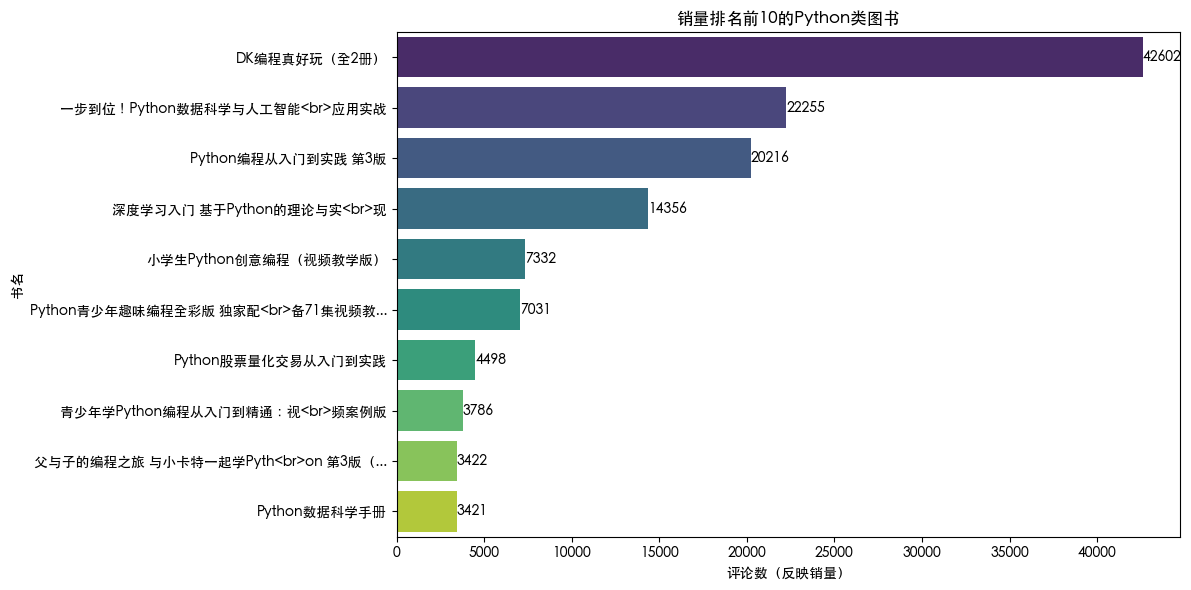

In [8]:
# 2. 销量排名前 10 的 Python 类图书清单
if df_processed is not None and 'review_count' in df_processed.columns and 'title' in df_processed.columns:
    print("\n分析问题2：销量排名前10的Python类图书清单")
    
    # 按评论数排序（假设评论数反映销量）
    top_10_books = df_processed.sort_values('review_count', ascending=False).head(10)
    
    # 表格使用30字符宽度，超过则省略号替代
    def truncate_text(text, max_len=30):
        """将文本截断到指定长度并添加省略号"""
        if not isinstance(text, str):
            text = str(text)
        if len(text) <= max_len:
            return text
        else:
            return text[:max_len-3] + "..."
    
    top_10_books['title_table'] = top_10_books['title'].apply(lambda x: truncate_text(x, 30))
    top_10_books['author_table'] = top_10_books['author'].apply(lambda x: truncate_text(x, 20))
    
    # 图表使用20字符宽度换行，超过30字符省略号替代
    def wrap_and_truncate(text):
        """按指定长度自动换行并截断过长文本"""
        wrapped = wrap_text(text, 20)  # 先按20字符换行
        lines = wrapped.split('<br>')
        if len(lines) > 1:  # 如果有多行
            if len(lines[0]) + len(lines[1]) > 30:  # 前两行总长度超过30
                return lines[0] + '<br>' + lines[1][:30-len(lines[0])-3] + "..."
            else:
                return wrapped[:30] + ("..." if len(wrapped) > 30 else "")
        else:  # 只有一行
            return wrapped[:30] + ("..." if len(wrapped) > 30 else "")
    
    top_10_books['title_chart'] = top_10_books['title'].apply(wrap_and_truncate)
    
    # 准备表格数据
    display_data = top_10_books[['title_table', 'author_table', 'review_count']].copy()
    display_data.columns = ['书名', '作者', '评论数']
    display_data.insert(0, '排名', range(1, 11))
    
    # 定义列和最大宽度（表格使用30字符宽度）
    columns = ['排名', '书名', '作者', '评论数']
    max_widths = {
        '排名': 2,
        '书名': 30,  # 表格书名扩展到30字符
        '作者': 20,  # 作者列相应调整
        '评论数': 10
    }
    
    # 显示表格
    display_table(display_data, columns, max_widths, "销量排名前10的Python类图书")
    
    # 中文字体检测和设置
    import matplotlib.font_manager as fm
    
    chinese_fonts = [
        'SimHei', 'WenQuanYi Micro Hei', 'Heiti TC', 
        'Microsoft YaHei', 'SimSun', 'Heiti TC'
    ]
    
    available_fonts = {f.name for f in fm.fontManager.ttflist}
    system_chinese_font = None
    
    for font in chinese_fonts:
        if font in available_fonts:
            system_chinese_font = font
            break
    
    if system_chinese_font:
        plt.rcParams["font.family"] = system_chinese_font
        plt.rcParams['axes.unicode_minus'] = False
        print(f"成功设置中文字体: {system_chinese_font}")
    else:
        print("警告：未找到支持中文的字体，图表中的中文可能无法正确显示")
    
    # 绘制柱状图（使用处理后的书名）
    plt.figure(figsize=(12, 6))
    
    ax = sns.barplot(x='review_count', y='title_chart', data=top_10_books, 
                     palette='viridis', hue='title_chart', dodge=False, legend=False)
    
    plt.title('销量排名前10的Python类图书')
    plt.xlabel('评论数（反映销量）')
    plt.ylabel('书名')
    
    # 在柱状图上添加数值标签
    for i, v in enumerate(top_10_books['review_count']):
        ax.text(v + 5, i, str(v), color='black', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("数据中缺少必要的列，无法分析销量排名前10的图书")



# 3. 销量前 50 的 Python 类图书主要涵盖了哪些领域


分析问题3：销量前50的Python类图书主要涵盖了哪些领域

销量前50的Python类图书领域分布:
--------------------------
| 领域_table  | 数量 | 占比    |
--------------------------
| 其他        | 22 | 44.0% |
| 编程基础      | 9  | 18.0% |
| 机器学习/深度学习 | 8  | 16.0% |
| 数据分析      | 5  | 10.0% |
| 青少年编程     | 2  | 4.0%  |
| 自动化/测试    | 2  | 4.0%  |
| 科学计算      | 1  | 2.0%  |
| 数据结构与算法   | 1  | 2.0%  |
--------------------------


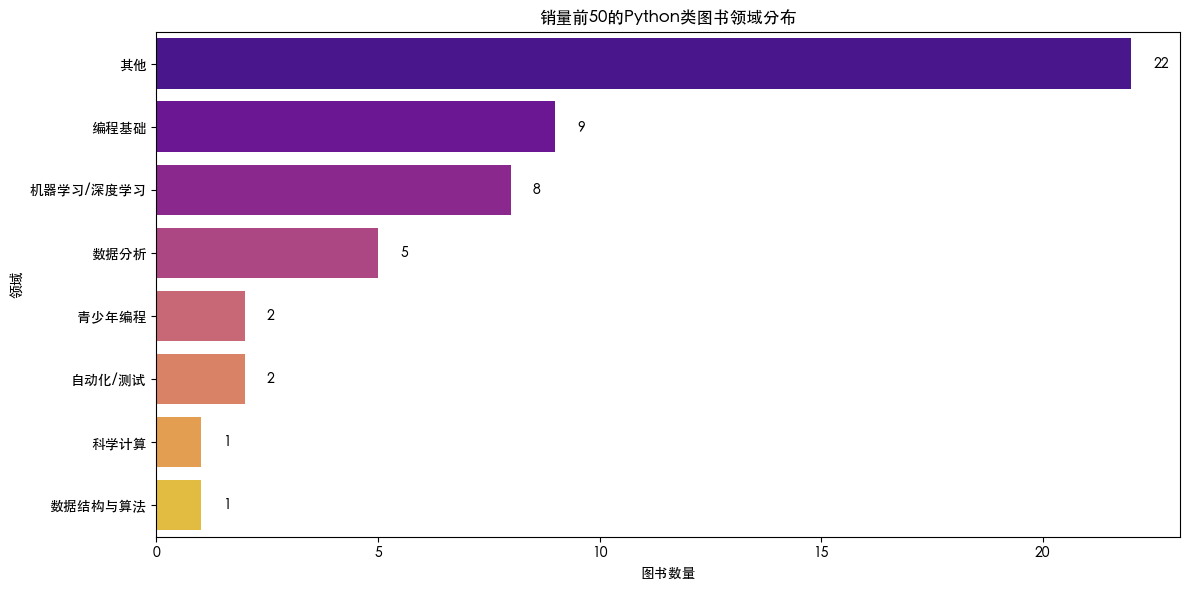

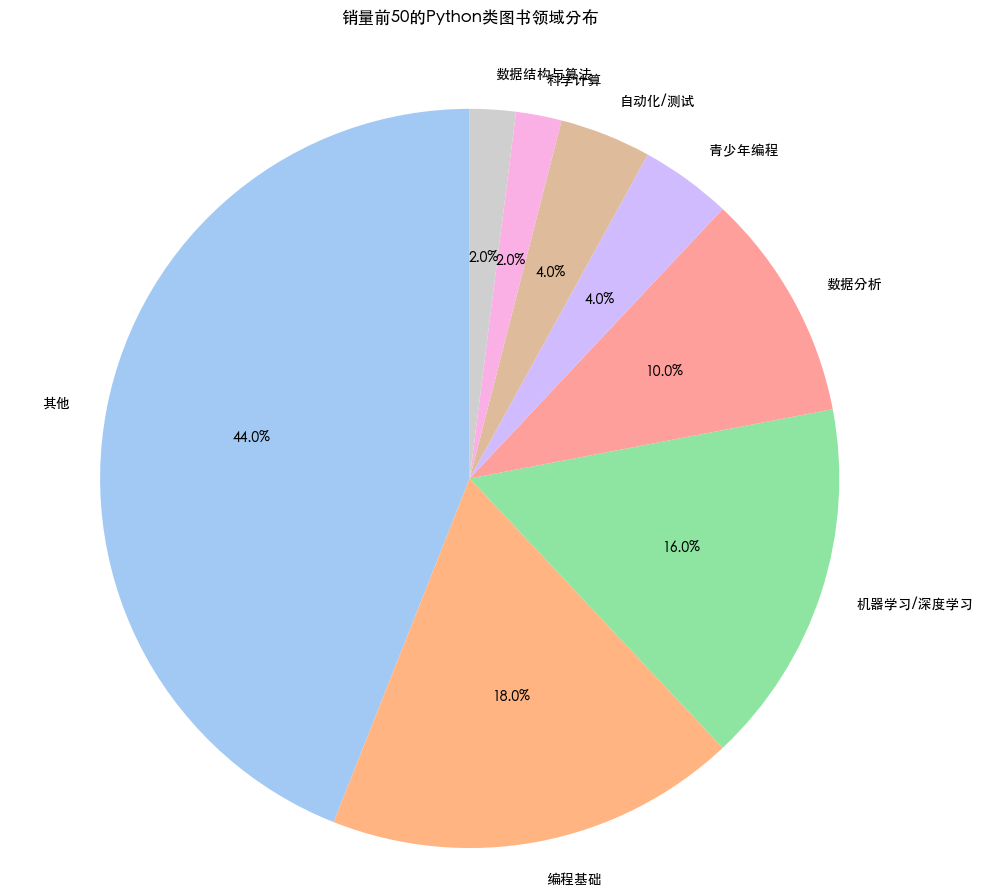


各领域图书数量分布：
- 其他: 22本 (44.0%)
- 编程基础: 9本 (18.0%)
- 机器学习/深度学习: 8本 (16.0%)
- 数据分析: 5本 (10.0%)
- 青少年编程: 2本 (4.0%)
- 自动化/测试: 2本 (4.0%)
- 科学计算: 1本 (2.0%)
- 数据结构与算法: 1本 (2.0%)


In [9]:
# 3. 销量前 50 的 Python 类图书主要涵盖了哪些领域
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict, Counter

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 定义辅助函数
def truncate_text(text, max_length):
    """截断文本并添加省略号"""
    if len(text) <= max_length:
        return text
    else:
        return text[:max_length-3] + "..."

def wrap_and_truncate(text, wrap_length=20, truncate_length=30):
    """将文本按指定长度换行，并在超过指定长度时截断"""
    # 截断文本
    if len(text) > truncate_length:
        text = text[:truncate_length-3] + "..."
    
    # 按指定长度换行
    wrapped_text = ''
    for i in range(0, len(text), wrap_length):
        wrapped_text += text[i:i+wrap_length] + '\n'
    
    return wrapped_text.rstrip('\n')  # 移除末尾的换行符

def display_table(df, columns, max_widths, title="数据表格"):
    """格式化显示表格数据"""
    print(f"\n{title}:")
    # 计算每列的最大宽度
    header_widths = [len(str(c)) for c in columns]
    data_widths = [[len(str(row[col])) for col in columns] for _, row in df.iterrows()]
    col_widths = [max(hw, max(dw)) for hw, dw in zip(header_widths, zip(*data_widths))]
    
    # 限制列宽不超过最大值
    col_widths = [min(w, max_widths.get(col, w)) for col, w in zip(columns, col_widths)]
    
    # 打印表头
    header = "| " + " | ".join([str(c).ljust(w) for c, w in zip(columns, col_widths)]) + " |"
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    
    # 打印数据行
    for _, row in df.iterrows():
        row_data = [str(row.get(col, "")).ljust(w) for col, w in zip(columns, col_widths)]
        print("| " + " | ".join(row_data) + " |")
    
    print("-" * len(header))

# 执行分析
print("\n分析问题3：销量前50的Python类图书主要涵盖了哪些领域")

if df_processed is not None and 'review_count' in df_processed.columns and 'title' in df_processed.columns:
    # 获取销量前50的图书
    top_50_books = df_processed.sort_values('review_count', ascending=False).head(50)
    
    # 定义领域分类规则
    def classify_domain(title):
        title = title.lower()
        if re.search(r'数据分析|数据挖掘|data analysis|data mining', title):
            return '数据分析'
        elif re.search(r'机器学习|深度学习|人工智能|machine learning|deep learning|ai', title):
            return '机器学习/深度学习'
        elif re.search(r'编程基础|入门|教程|基础教程|beginner|tutorial', title):
            return '编程基础'
        elif re.search(r'web开发|web编程|django|flask|web development', title):
            return 'Web开发'
        elif re.search(r'爬虫|scraping|crawler', title):
            return '网络爬虫'
        elif re.search(r'游戏开发|game development', title):
            return '游戏开发'
        elif re.search(r'自动化|测试|automation|test', title):
            return '自动化/测试'
        elif re.search(r'青少年|kids|children', title):
            return '青少年编程'
        elif re.search(r'数据结构|算法|data structure|algorithm', title):
            return '数据结构与算法'
        elif re.search(r'科学计算|numpy|pandas|matplotlib|scientific computing', title):
            return '科学计算'
        elif re.search(r'GUI|tkinter|pyqt|wxpython', title):
            return 'GUI开发'
        elif re.search(r'网络编程|socket|network programming', title):
            return '网络编程'
        else:
            return '其他'
    
    # 对图书进行领域分类
    top_50_books['domain'] = top_50_books['title'].apply(classify_domain)
    
    # 统计各领域图书数量
    domain_counts = top_50_books['domain'].value_counts().reset_index()
    domain_counts.columns = ['领域', '数量']
    
    # 计算占比
    domain_counts['占比'] = (domain_counts['数量'] / domain_counts['数量'].sum() * 100).map('{:.1f}%'.format)
    
    # 表格数据处理：30字符截断并添加省略号
    domain_counts['领域_table'] = domain_counts['领域'].apply(lambda x: truncate_text(x, 30))
    
    # 定义列和最大宽度
    columns = ['领域_table', '数量', '占比']
    max_widths = {
        '领域_table': 30,  # 扩展到30字符
        '数量': 10,
        '占比': 10
    }
    
    # 显示表格
    display_table(domain_counts, columns, max_widths, "销量前50的Python类图书领域分布")
    
    # 图表数据处理：20字符换行，超过30字符省略
    domain_counts['领域_chart'] = domain_counts['领域'].apply(lambda x: wrap_and_truncate(x, 20, 30))
    
    # 绘制柱状图
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='数量', y='领域_chart', data=domain_counts, 
                     palette='plasma', hue='领域_chart', dodge=False, legend=False)
    plt.title('销量前50的Python类图书领域分布')
    plt.xlabel('图书数量')
    plt.ylabel('领域')
    
    # 添加数值标签
    for i, v in enumerate(domain_counts['数量']):
        ax.text(v + 0.5, i, str(v), va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 绘制饼图
    plt.figure(figsize=(10, 9))  # 增加图表高度，避免标题重叠
    wedges, labels, autotexts = plt.pie(
        domain_counts['数量'],
        labels=domain_counts['领域_chart'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'),
        textprops={'fontsize': 10}  # 减小标签字体大小
    )
    
    plt.title('销量前50的Python类图书领域分布', y=1.05)  # 调整标题位置
    
    # 调整图例与图表的间距
    plt.subplots_adjust(top=0.85, bottom=0.1)  # 留出顶部空间
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 打印领域分布数据
    print("\n各领域图书数量分布：")
    for _, row in domain_counts.iterrows():
        print(f"- {row['领域']}: {row['数量']}本 ({row['占比']})")
else:
    print("数据中缺少必要的列，无法分析图书领域分布")

# 4. 销量前 50 的 Python 类图书中，哪些出版社的书籍比较多


分析问题4：销量前50的Python类图书中，哪些出版社的书籍比较多

销量前50的Python类图书出版社分布（前10）:
--------------------------
| 出版社_table | 数量 | 占比    |
--------------------------
| 人民邮电出版社   | 25 | 51.0% |
| 未知        | 10 | 20.4% |
| 清华大学出版社   | 6  | 12.2% |
| 机械工业出版社   | 2  | 4.1%  |
| 南海出版公司    | 1  | 2.0%  |
| 未提供       | 1  | 2.0%  |
| 水利水电出版社   | 1  | 2.0%  |
| 北京理工大学出版社 | 1  | 2.0%  |
| 高等教育出版社   | 1  | 2.0%  |
| 电子工业出版社   | 1  | 2.0%  |
--------------------------


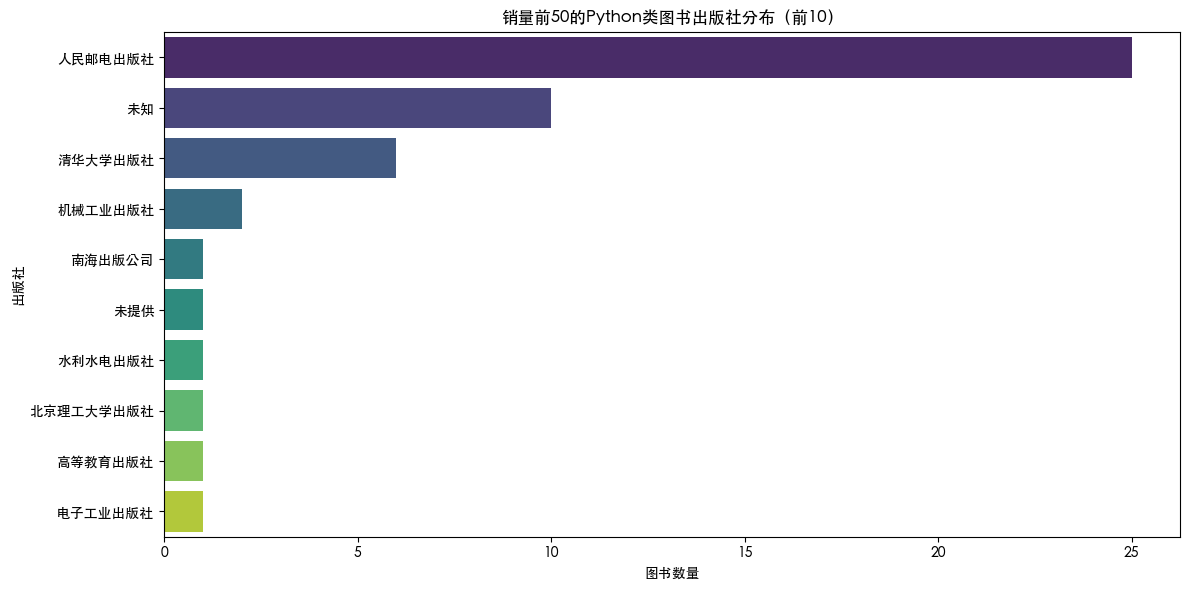

In [10]:
# 4. 销量前 50 的 Python 类图书中，哪些出版社的书籍比较多
if df_processed is not None and 'review_count' in df_processed.columns and 'publisher' in df_processed.columns:
    print("\n分析问题4：销量前50的Python类图书中，哪些出版社的书籍比较多")
    
    top_50_books = df_processed.sort_values('review_count', ascending=False).head(50).copy()
    publisher_counts = top_50_books['publisher'].value_counts().reset_index()
    publisher_counts.columns = ['出版社', '数量']
    top_publishers = publisher_counts.head(10).copy()
    
    # 计算占比（使用loc避免警告）
    top_publishers.loc[:, '占比'] = (top_publishers['数量'] / top_publishers['数量'].sum() * 100).map('{:.1f}%'.format)
    top_publishers.loc[:, '出版社_table'] = top_publishers['出版社'].apply(lambda x: truncate_text(x, 30))
    
    columns = ['出版社_table', '数量', '占比']
    max_widths = {
        '出版社_table': 30,
        '数量': 10,
        '占比': 10
    }
    
    display_table(top_publishers, columns, max_widths, "销量前50的Python类图书出版社分布（前10）")
    
    # 图表数据处理（添加hue参数并关闭图例）
    top_publishers.loc[:, '出版社_chart'] = top_publishers['出版社'].apply(lambda x: wrap_and_truncate(x, 20, 30))
    
    plt.figure(figsize=(12, 6))
    # 使用hue参数并设置legend=False
    sns.barplot(
        x='数量', 
        y='出版社_chart', 
        data=top_publishers, 
        palette='viridis', 
        hue='出版社_chart',  # 传递hue避免警告
        dodge=False,         # 禁止分组偏移
        legend=False         # 关闭图例
    )
    
    plt.title('销量前50的Python类图书出版社分布（前10）')
    plt.xlabel('图书数量')
    plt.ylabel('出版社')
    plt.tight_layout()
    plt.show()
else:
    print("数据中缺少必要的列，无法分析出版社分布")

# 5. 销量前 50 的 Python 类图书中，原价和折后价的分布，折扣率的分布特征


分析问题5：销量前50的Python类图书中，原价和折后价的分布，折扣率的分布特征

价格与折扣率统计摘要:
---------------------------------------------------------------------------------
| 统计指标             | 计数   | 均值    | 标准差   | 最小值  | 25%分位 | 中位数  | 75%分位 | 最大值   |
---------------------------------------------------------------------------------
| original_price   | 50.0 | 96.45 | 37.98 | 39.8 | 72.1  | 89.8 | 106.0 | 268.6 |
| discounted_price | 50.0 | 80.98 | 36.18 | 37.8 | 55.5  | 85.3 | 94.8  | 255.2 |
| discount_rate    | 50.0 | 0.16  | 0.17  | 0.0  | 0.05  | 0.05 | 0.34  | 0.5   |
---------------------------------------------------------------------------------

折扣率分组统计:
-------------------------
| 折扣区间   | 图书数量 | 占比    |
-------------------------
| 0-10%  | 32   | 64.0% |
| 10-20% | 3    | 6.0%  |
| 20-30% | 2    | 4.0%  |
| 30-40% | 2    | 4.0%  |
| 40-50% | 10   | 20.0% |
| 50-60% | 1    | 2.0%  |
-------------------------


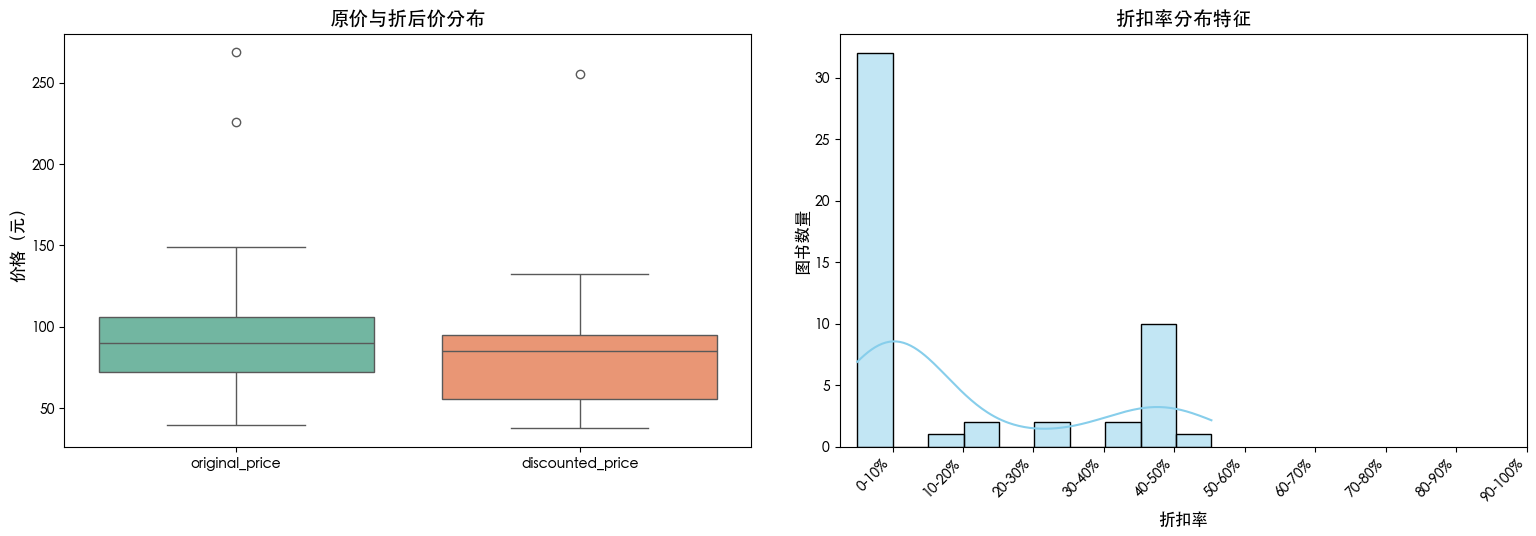

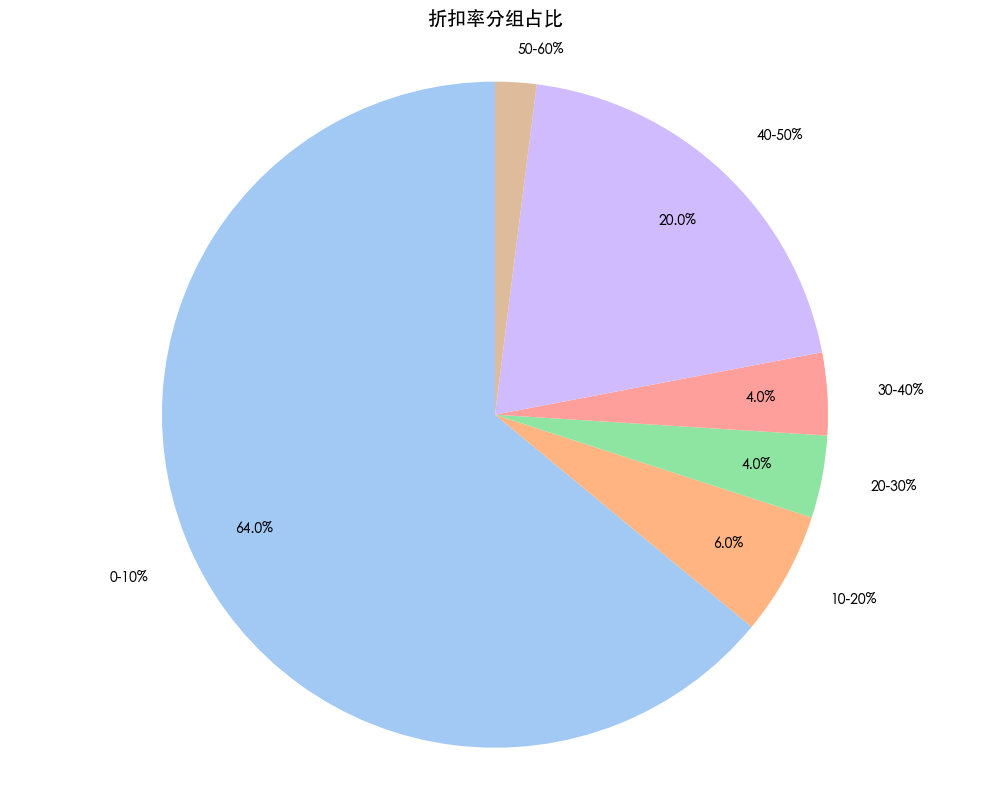

In [11]:
# 5. 销量前 50 的 Python 类图书中，原价和折后价的分布，折扣率的分布特征
if df_processed is not None and all(col in df_processed.columns for col in ['review_count', 'original_price', 'discounted_price', 'discount_rate']):
    print("\n分析问题5：销量前50的Python类图书中，原价和折后价的分布，折扣率的分布特征")
    
    # 获取销量前50的图书并过滤无效数据
    top_50_books = df_processed.sort_values('review_count', ascending=False).drop_duplicates().head(50)
    valid_price_data = top_50_books[(top_50_books['original_price'] > 0) & (top_50_books['discounted_price'] > 0)]
    
    # 价格和折扣率统计
    price_stats = valid_price_data[['original_price', 'discounted_price', 'discount_rate']].describe().round(2)
    price_stats = price_stats.T.reset_index()
    price_stats.columns = ['统计指标', '计数', '均值', '标准差', '最小值', '25%分位', '中位数', '75%分位', '最大值']
    
    # 显示统计表格
    display_table(price_stats, ['统计指标'] + list(price_stats.columns[1:]), {col: 20 for col in price_stats.columns}, "价格与折扣率统计摘要")
    
    # 折扣率分组统计
    discount_bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    discount_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
    valid_price_data['discount_group'] = pd.cut(valid_price_data['discount_rate'], bins=discount_bins, labels=discount_labels, include_lowest=True)
    discount_group_counts = valid_price_data['discount_group'].value_counts(sort=False).reset_index()
    discount_group_counts.columns = ['折扣区间', '图书数量']
    discount_group_counts = discount_group_counts[discount_group_counts['图书数量'] > 0]
    discount_group_counts['占比'] = (discount_group_counts['图书数量'] / discount_group_counts['图书数量'].sum() * 100).map('{:.1f}%'.format)
    
    # 显示分组表格
    display_table(discount_group_counts, ['折扣区间', '图书数量', '占比'], {'折扣区间': 15, '图书数量': 10, '占比': 10}, "折扣率分组统计")
    
    # 绘制价格分布箱线图
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=valid_price_data[['original_price', 'discounted_price']], palette='Set2')
    plt.title('原价与折后价分布', fontsize=14)
    plt.ylabel('价格（元）', fontsize=12)
    plt.xticks(fontsize=10)
    
    # 绘制折扣率分布直方图
    plt.subplot(1, 2, 2)
    sns.histplot(valid_price_data['discount_rate'], kde=True, bins=10, color='skyblue', edgecolor='black')
    plt.title('折扣率分布特征', fontsize=14)
    plt.xlabel('折扣率', fontsize=12)
    plt.ylabel('图书数量', fontsize=12)
    
    # 修复刻度与标签数量不匹配问题
    plt.xticks(
        np.linspace(0.05, 0.95, 10),  # 生成10个刻度点
        discount_labels,  # 使用10个标签
        rotation=45,
        ha='right'
    )
    
    plt.tight_layout(pad=3)
    plt.show()
    
    # 绘制折扣率分组饼图（优化标签位置）
    plt.figure(figsize=(10, 8))
    
    # 调整子图布局
    plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.9)
    
    wedges, labels, autotexts = plt.pie(
        discount_group_counts['图书数量'],
        labels=discount_group_counts['折扣区间'],
        autopct=lambda p: '{:.1f}%'.format(p) if p > 3 else '',
        startangle=90,
        colors=sns.color_palette('pastel'),
        textprops={'fontsize': 10},
        pctdistance=0.8
    )
    
    # 调整标题位置
    plt.title('折扣率分组占比', fontsize=14, y=1.02)
    
    # 自定义标签位置（重点解决50%-60%离得远的问题）
    label_distances = {
        '0-10%': 1.15,
        '10-20%': 1.15,
        '20-30%': 1.15,
        '30-40%': 1.15,
        '40-50%': 1.15,
        '50-60%': 1.10,  # 特别调整这个标签的距离，使其更靠近饼图
        '60-70%': 1.15,
        '70-80%': 1.15,
        '80-90%': 1.15,
        '90-100%': 1.15,
    }
    
    # 应用自定义标签位置
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        
        # 根据标签文本设置不同的距离
        distance = label_distances.get(label.get_text(), 1.2)
        label.set_position((x * distance, y * distance))
    
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("数据中缺少必要列（review_count/original_price/discounted_price/discount_rate），无法分析价格和折扣率分布")